In [1]:
import os

import torch
import pandas as pd
import numpy as np

from collections import Counter

## OPTIONS

In [2]:
nrows = 1000
min_freq = 1

train_data_path = "../../data/toy_dataset/data/train.csv"
valid_data_path = "../../data/toy_dataset/data/val.csv"

model_save_path = './sample_model/simple_lstm_201215'
results_save_path = "./sample_results/simple_results_201215"
batch_size = 64
n_epochs = 5

embedding_dim = 8
hidden_dim = 16
bidirectional = True
dropout = 0.3

target_colname = 'label'
uid_colname = 'patient_id'
x_inputs = [str(x) for x in range(29, -1, -1)]
target_value = '1'

In [3]:
for fp in [model_save_path, results_save_path]:
    if not os.path.isdir(os.path.split(fp)[0]):
        print(f'New directory created: {fp}')
        os.makedirs(os.path.split(fp)[0])

print(f"Cuda available: {torch.cuda.is_available()}")
model_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cuda available: True


## Create Vocab

equivalent to model.create_word_id_dict

In [4]:
datapath = train_data_path
rev = False

In [5]:
def valid_token(t):
    if len(t) == 0 or t.lower() == "<pad>":
        return False
    return True

In [8]:
token_list = []
with open(datapath, "r") as f:
    # determine column mapping
    header = f.readline()
    header = [h.replace(" ", "").replace("\n", "") for h in header.split(",")]

    target_index = header.index(target_colname)

    uid_index = header.index(uid_colname)

    x_idxes = []
    for colname in x_inputs:
        x_idxes.append(header.index(colname))

    # start processing 
    line = f.readline()
    invalid_uid = 0
    deaths = 0
    while line:
        if 'death' in line:
            deaths += 1
            pass

        tokens = line.split(",")

        if len(tokens[uid_index]) == 0:
            invalid_uid += 1 # some UIDS are missing
            pass
        else:
            uid = tokens[uid_index].replace('\n', '')

        ## CHANGE: integer
        if isinstance(tokens[target_index], str):
            label = 1 if tokens[target_index].startswith(target_value) else 0
        
        if isinstance(tokens[target_index], int):
            label = tokens[target_index]

        tokens = [tokens[idx] for idx in x_idxes]
        tokens = [t.strip().replace('\n', '') for t in tokens if valid_token(t)]

        if rev:
            tokens = tokens[::-1]

        token_list.append((uid, label, tokens))

        line = f.readline()

        if len(token_list) == nrows:
            break

Define vocabulary without torchtext

In [14]:
vocab = {}
vocab['<pad>'] = 0
vocab['<unk>'] = 1

rev_vocab = {}
rev_vocab[0] = '<pad>'
rev_vocab[1] = '<unk>'

counter = Counter()
for uid, label, tokens in token_list:
    for token in tokens:
        counter[token] += 1

for token in counter:
    if counter[token] < min_freq:
        continue
        
    idx = len(vocab)
    vocab[token] = idx
    rev_vocab[idx] = token

class Vocab:
    def __init__(self, vocab, rev_vocab):
        self._vocab = vocab
        self._rev_vocab = rev_vocab
        self._unk_idx = vocab['<unk>']
        self._pad_idx = vocab['<pad>']
    
    def __len__(self):
        return len(self._vocab)
    
    def stoi(self, token):
        if token in self._vocab:
            return self._vocab[token]
        return self._vocab['<unk>']
    
    def itos(self, idx):
        if idx in self._rev_vocab:
            return self._rev_vocab[idx]
        return self._unk_idx
    

In [15]:
len(vocab)

32

In [16]:
vocab

{'<pad>': 0,
 '<unk>': 1,
 'annual_physical': 2,
 'foot_pain': 3,
 'eye_exam': 4,
 'hay_fever': 5,
 'ACE_inhibitors': 6,
 'ingrown_nail': 7,
 'cold_sore': 8,
 'dental_exam': 9,
 'apnea': 10,
 'PCI': 11,
 'backache': 12,
 'cut_finger': 13,
 'ankle_sprain': 14,
 'quad_injury': 15,
 'high_creatinine': 16,
 'resistent_hyp': 17,
 'tachycardia': 18,
 'myopia': 19,
 'CHF': 20,
 'headache': 21,
 'normal_bmi': 22,
 'cardiac_rehab': 23,
 'low_salt_diet': 24,
 'ACL_tear': 25,
 'peanut_allergy': 26,
 'pneumonia': 27,
 'AMI': 28,
 'PH': 29,
 'furosemide': 30,
 'ARR': 31}

In [18]:
vocab_class = Vocab(vocab, rev_vocab)

**Create dataset and dataloader**

In [19]:
data = [
    (pid, [label], [vocab_class.stoi(t) for t in tokens])
    for pid, label, tokens in token_list
]

In [20]:
data[3]

('DU5LE6OJSR', [0], [21, 22, 23, 24])

In [21]:
from torch.utils.data import Dataset, DataLoader

In [23]:
class ToyDataset(Dataset):
    '''
    Similar to transformer's, adapted to this dataset with Marc's line by line reading output
    '''
    
    def __init__(self, data, max_len=35, pad_idx=0):
        self.data = data
        self.max_len = max_len
        self.pad_idx = pad_idx
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        idx_lst = data[idx][2]
        if len(idx_lst) > self.max_len:
            idx_lst = idx_lst[:self.max_len]
        idx_lst = idx_lst + [self.pad_idx] * (self.max_len - len(idx_lst))
            
        return (
            data[idx][0],
            torch.tensor(data[idx][1]),
            torch.tensor(idx_lst) 
        )

In [24]:
toy_dataset = ToyDataset(data, max_len=30)

In [26]:
train_dataloader = DataLoader(
    toy_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

In [27]:
next(iter(train_dataloader))

[('KWPSWXBCOO',
  'OAB32HBRGF',
  'GVKVDO2JQP',
  'DU5LE6OJSR',
  'EYL9OAO7UU',
  'EA3Y23B5G4',
  'HA9XRJBP80',
  'GSD914SV90',
  'AI58JP94TT',
  '1BFRROCHC9',
  '7XFPYN3G6K',
  'AIRXLC21GS',
  'BKD87ZKI6X',
  'P4QJBL4D9U',
  'UPOO9PS06M',
  'RNW0E98SKN',
  'CQ4UYADG1U',
  'AIXRRUPL62',
  'F2UBVPAOL2',
  'OXL8BE7K0X',
  '94NSP0QGZL',
  'L7VFUQT4AP',
  '3LMWS2U7KE',
  'NGOXR1IT77',
  'WGIIXYGPEQ',
  'VH5QT1BR9C',
  '1R4IP7CEUB',
  '7A1OQ4W91A',
  '4TMHC604U5',
  'O2XPIZBL96',
  '9UX6ZVXL1Q',
  '7L1IZ18Z74',
  '9SJY4TSXJR',
  '302YJ2ZEMT',
  'BMKYCDP4LN',
  'W842GUPG7Q',
  '21AW4N8JKC',
  'ZGWVOTQVQZ',
  '4I1RJPR5A7',
  'DQ6SIIE0I8',
  '4ERS8UHLXC',
  'E6R21HM4YQ',
  'LQSUVM7RPK',
  'E67ZJ93TOR',
  'D46MWQ6RSJ',
  'SDUUKOGA8R',
  '62YBG3WVFS',
  '0B2MCYWFG7',
  'FLKD8Y953C',
  '6YZJHL5S9J',
  'YL3NRAWKGK',
  'KBMKJ9XHFW',
  'ZZT9Y30HP2',
  'B2HSUU7ALJ',
  'GQCSIL3P1O',
  'U2OKF5O8IE',
  '2IEBXML89S',
  'R1RB6W9KL7',
  'OUEY62N32C',
  'YU03WA1QGR',
  '4Q428PHYFQ',
  'H468KCYCTX',
  'GF603

## Model definition

In [28]:
model_device

device(type='cuda')

In [29]:
import torch
import torch.nn as nn

In [31]:
class SimpleLSTM(nn.Module):
    def __init__(self, emb_dim, hidden_dim, vocab, device, nlayers=1, bidi=True, use_gpu=True,
                 pad_idx=0):
        super(SimpleLSTM, self).__init__()
        
        self.device = device
        self.use_gpu = use_gpu
        
        self.emb_dim = emb_dim
        self.input_dim = len(vocab)
        self.vocab = vocab
        self.pad_idx = pad_idx
        self.emb_layer = nn.Embedding(self.input_dim, emb_dim, padding_idx=pad_idx)
        
        self.hidden_dim = hidden_dim
        self.bidi = bidi
        self.nlayers = nlayers
        self.lstm = nn.LSTM(input_size=emb_dim,
                            hidden_size=hidden_dim,
                            num_layers=nlayers,
                            bidirectional=bidi,
                            batch_first=True)
        
        self.pred_layer = nn.Linear(hidden_dim * 2, 2) if bidi else nn.Linear(hidden_dim, 2)
        
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.3
        self.emb_layer.weight.data.uniform_(-initrange, initrange) 
        
        self.pred_layer.weight.data.uniform_(-initrange, initrange)
        self.pred_layer.bias.data.zero_()   
        
    def init_hidden(self, batch_size):
        count = self.nlayers * 2 if self.bidi else self.nlayers
        
        weight = next(self.parameters())
        
        directionality = 2 if self.bidi else 1
        weights = (
            weight.new_zeros(count * directionality, batch_size, self.hidden_dim),
            weight.new_zeros(count * directionality, batch_size, self.hidden_dim)
        )
        
        if self.use_gpu:
            return (weights[0].cuda(), weights[1].cuda())
        
        return weights
        
    def repackage_hidden(h):
        """
        Wraps hidden states in new Tensors, to detach them from their history.
        Needed to prevent RNN+Attention backpropagating between batches.
        """
        if isinstance(h, torch.Tensor):
            return h.detach()
        
        if isinstance(h, tuple):
            return (v.detach() for v in h)
    
        
    def forward(self, tokens):
        embedded = self.emb_layer(tokens)
        
        hidden = self.init_hidden(tokens.shape[0])
        hidden = self.repackage_hidden()
        
        text_lengths = torch.sum(tokens != self.pad_idx, dim=1)
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths, enforce_sorted=False, batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded, hidden)
        
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        output = output.permute(1, 0, 2) # [batch, text_length, hidden_dim]
        
        if self.bidi:
            out = torch.cat([output[:, -1, :self.hidden_dim], output[:, 0, self.hidden_dim:]],
                           dim=1)
        else:
            out = output[:, -1, :]
        
        pred = self.pred_layer(out)
        
        return pred
    
    def save_model(self, filepath):
        if not os.path.isdir(os.path.split(filepath)[0]):
            os.makedirs(os.path.split(filepath)[0])
        torch.save({self.state_dict()}, filepath)
                   
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        
    def get_ids_masks(self, token_list, padding_length):
        '''Only enabled for one example at a time'''
        ids, masks = np.zeros((padding_length, len(self.vocab))), [0] * padding_length
        
        for (i, idx_token) in enumerate(token_list):
            if i >= padding_length or idx_token == self.pad_idx:
                break
            ids[i, idx_token] = 1
            masks[i] = 1

        return torch.FloatTensor(ids), masks
    
    def get_all_ids_masks(self, data, padding_length):
        ids,  masks = [], []
        for obs in data:
            id_vals, mask_vals = self.get_ids_masks(obs, padding_length)
            ids.append(id_vals)
            masks.append(mask_vals)
            
        return torch.stack(ids), masks
    
    def forward_shap(self, token_ids, mask, full_id_matrix=False):
        '''Only enabled for one example at a time'''
        token_ids = token_ids if token_ids.is_cuda else token_ids.cuda()
        
        hidden = self.init_hidden(1)
        hidden = self.repackage_hidden()
        
        emb = torch.matmul(token_ids, self.emb_layer.weight).unsqueeze(0)
        
        out, _ = self.lstm(emb, hidden)
        
        return self.pred_layer(out).squeeze(0)

In [32]:
single = next(iter(train_dataloader))

In [39]:
single[2]

tensor([[ 2,  3,  4,  ...,  0,  0,  0],
        [ 3, 12, 13,  ...,  0,  0,  0],
        [18,  7,  9,  ...,  0,  0,  0],
        ...,
        [14,  4,  9,  ...,  0,  0,  0],
        [ 8, 19, 12,  ...,  0,  0,  0],
        [19, 28, 26,  ...,  0,  0,  0]])

In [40]:
torch.sum(single[2] != 0, dim=1)

tensor([14, 12, 10,  4, 18, 24, 28,  6, 14, 24, 18,  9, 10, 26, 15,  4, 26, 26,
        25, 20,  9, 26, 21,  3,  7,  9, 12,  6, 28, 11, 28, 23, 27,  7,  6, 19,
        27, 17, 21,  4,  4, 25, 26, 10,  5, 16, 14,  4, 29, 15, 27, 26, 27,  8,
        25, 27, 14, 11, 12, 22,  5, 19, 12, 18])

In [41]:
single[2][2]

tensor([18,  7,  9,  9, 19,  7,  2, 12,  5, 20,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [42]:
type(single[1])

torch.Tensor

In [43]:
single[1]

tensor([[0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0]])

In [44]:
single[2].is_cuda

False

In [45]:
model = SimpleLSTM(embedding_dim, hidden_dim, vocab_class, model_device)
model = model.cuda()

In [46]:
model

SimpleLSTM(
  (emb_layer): Embedding(32, 8, padding_idx=0)
  (lstm): LSTM(8, 16, batch_first=True, bidirectional=True)
  (pred_layer): Linear(in_features=32, out_features=2, bias=True)
)

In [47]:
model_device

device(type='cuda')

In [48]:
model.device

device(type='cuda')

In [49]:
model.emb_layer.weight.shape

torch.Size([32, 8])

In [50]:
preds = model(single[2].cuda())

RuntimeError: 'lengths' argument should be a 1D CPU int64 tensor, but got 1D cuda:0 Long tensor

In [222]:
toy_dataset[0]

('YY7IC1FOD3',
 tensor([0]),
 tensor([ 2,  3,  4,  5,  6,  7,  8,  4,  2,  2,  9,  8,  4, 10, 11,  8,  4,  7,
         12,  7, 13, 14,  2, 15,  9,  7, 16, 17,  0,  0]))

In [223]:
token_list[3]

('YXRO57K7EL',
 1,
 ['annual_physical',
  'myopia',
  'backache',
  'annual_physical',
  'cut_finger',
  'ingrown_nail',
  'hay_fever',
  'peanut_allergy',
  'CHF'])

In [224]:
model.get_ids_masks(toy_dataset[3][2], 15)

(tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0.

In [225]:
ids, mask = model.get_ids_masks(toy_dataset[3][2], 15)

In [226]:
model.forward_shap(ids, mask).shape

torch.Size([15, 2])

In [126]:
import seaborn
import matplotlib.pyplot as plt

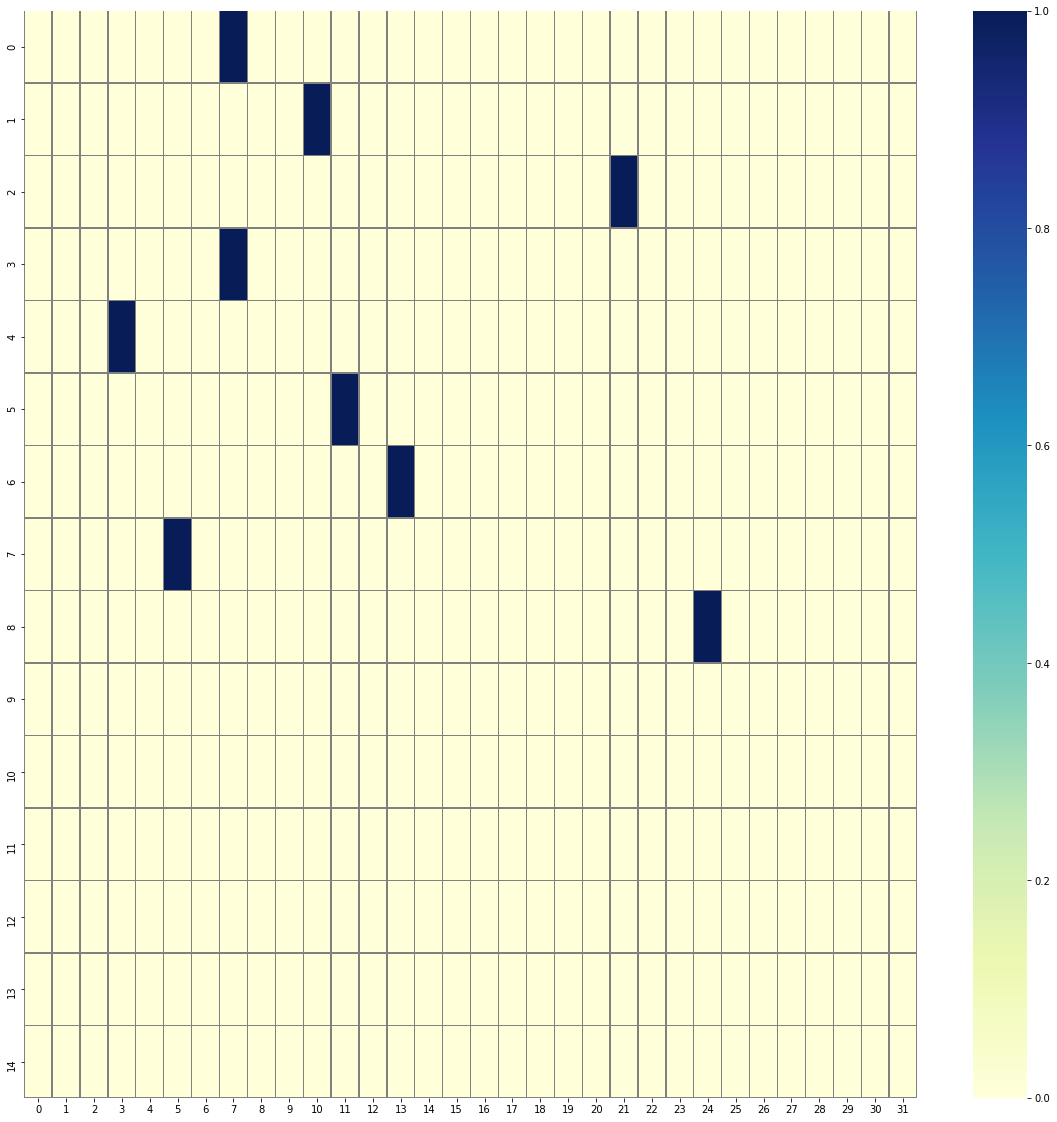

In [193]:
plt.figure(figsize=(20, 20))
seaborn.heatmap(model.get_ids_masks(toy_dataset[3][2], 15)[0],
                linewidths=0.4, cmap="YlGnBu", linecolor='gray', 
                vmin=0, vmax=1)

## Training loop

In [59]:
def epoch_train_lstm(
    model,
    dataloader,
    optimizer,
    criterion,
    test=0
):
    """
    Train model for an epoch, called by ModelProcess function
    detach_hidden is used to detach hidden state between batches,
    and will add a new hidden state to model. Model must have .init_hidden function defined
    
    Args:
    -----
        model (nn.Module): lstm general attention model
        dataloader : iterator for dataset, yields (ids, sequence, seq length, labels)
        criterion : loss function
        batch_size : int default 0
                     used when detach_hidden is enabled
                     to create the correct hidden sizes during initialization
        
    Returns:
    ----------
        tuple containing:
            average loss for whole epoch,
            average AUC for whole epoch
    """
    import copy
    from sklearn.metrics import roc_auc_score
           
    epoch_loss = 0
    epoch_metric = 0

    model.train()

    # initialize lists to compare predictions & ground truth labels for metric calculation
    order_labels = []
    prediction_scores = []
    if test: # test function on small number of batches
        counter = 0
        
    for idx, (ids, labels, idxed_text) in enumerate(dataloader):
        
        optimizer.zero_grad()
          
        labels = labels.type(torch.long)
        idxed_text, labels = idxed_text.cuda(), labels.cuda()

        predictions = model(idxed_text)        
        #predictions = model(text, text_lengths).squeeze(1)
        
        
        loss = criterion(predictions, labels.squeeze(1))
        loss.backward()
        optimizer.step()

        # prevent internal pytorch timeout due to too many file opens by multiprocessing
        copied_labels = copy.deepcopy(labels.detach().cpu().numpy())
        del labels
        order_labels.extend(copied_labels)
        
        copied_preds = copy.deepcopy(predictions.detach().cpu().numpy())
        del predictions
        prediction_scores.extend(copied_preds)
        
        epoch_loss += loss.item()        
    
        if test:
            if counter >= test:
                break
            counter += 1
    
    epoch_metric = roc_auc_score(order_labels, torch.sigmoid(torch.Tensor(prediction_scores)[:, 1]))
        
    return epoch_loss / len(dataloader), epoch_metric

In [60]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [62]:
epoch_train_lstm(
    model=model,
    dataloader=train_dataloader,
    optimizer=optimizer,
    criterion=loss_function,
    test=0    
)

(0.4665308780968189, 0.8722856091277145)

In [63]:
epoch_train_lstm(
    model=model,
    dataloader=train_dataloader,
    optimizer=optimizer,
    criterion=loss_function,
    test=0    
)

(0.3564494103193283, 0.9007537085340289)

In [64]:
import time

In [67]:
#best_valid_loss = float("inf")
#valid_worse_loss = 0  # enable early stopping
#stop_num = 6

for epoch in range(n_epochs):

    start_time = time.time()

    train_loss, train_auc = epoch_train_lstm(
        model, train_dataloader, optimizer, loss_function
    )

    #valid_loss, valid_auc = epoch_val_lstm(
    #    model, valid_dataloader, criterion, return_preds=False
    #)

    end_time = time.time()

    #epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    #print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")

    '''
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_save_path)
        print("Saved Model, epoch {}".format(epoch))
        valid_worse_loss = 0

    else:
        valid_worse_loss += 1
        if valid_worse_loss == stop_num:
            print("EARLY STOP ------")
            break

    scheduler.step()
    log(
        f"Train Loss: {train_loss:.3f} | Train AUC: {train_auc:.2f} \t Val. Loss: {valid_loss:.3f} |  Val. AUC: {valid_auc:.4f}"
    )'''
    
    print(
        f"Train Loss: {train_loss:.3f} | Train AUC: {train_auc:.2f}"
    )

Train Loss: 0.333 | Train AUC: 0.92
Train Loss: 0.326 | Train AUC: 0.93
Train Loss: 0.315 | Train AUC: 0.93
Train Loss: 0.306 | Train AUC: 0.94
Train Loss: 0.288 | Train AUC: 0.95


## GEt SHAP values

In [237]:
import deep_id_pytorch

In [238]:
background = next(iter(train_dataloader))
background_ids, background_labels, background_idxes = background

In [239]:
background_idxes.shape

torch.Size([64, 30])

In [240]:
bg_data, bg_masks = model.get_all_ids_masks(background_idxes, 20)

In [241]:
bg_data.shape

torch.Size([64, 20, 32])

In [242]:
explainer = deep_id_pytorch.CustomPyTorchDeepIDExplainer(model, bg_data, bg_masks,
                                                         gpu_memory_efficient=True)

64it [00:00, 919.04it/s]


In [243]:
model.train() # in case that shap complains that autograd cannot be called
lstm_values = []
features = []
start = 0

In [244]:
test = list(train_dataloader)[3]
test_ids, test_labels, test_idxes = test

In [245]:
test_data, test_masks = model.get_all_ids_masks(test_idxes, 20)

In [246]:
test_data[0].shape

torch.Size([20, 32])

In [247]:
len(test_masks[0])

20

In [249]:
lstm_shap_values = explainer.shap_values(test_data[0].unsqueeze(0), test_masks[0])

128it [00:00, 339.40it/s]
128it [00:00, 321.75it/s]
